# 1. Setup and Load Data

### 1.1 Install dependencies

In [ ]:
!pip install tensorflow
!pip install tensorflow-gpu
!pip install matplotlib
!pip install opencv-python

In [2]:
!pip list

Package                            Version
---------------------------------- -------------------
absl-py                            0.15.0
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-navigator                 1.9.7
anaconda-project                   0.8.3
asn1crypto                         0.24.0
astor                              0.8.1
astroid                            2.2.5
astropy                            3.2.1
astunparse                         1.6.3
atomicwrites                       1.3.0
attrs                              19.1.0
Babel                              2.7.0
backcall                           0.1.0
backports.functools-lru-cache      1.6.4
backports.os                       0.1.1
backports.shutil-get-terminal-size 1.0.0
backports.tempfile                 1.0
backports.weakref                  1.0.post1
backtrader                         1.9.76.123
beautifulsoup4                     4.7.1
bitarray                      

In [1]:
import tensorflow as tf
import os

In [2]:
os.path.join('data','happy')

'data\\happy'

In [2]:
# Avoid (Out Of Memory)OOM error set GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True) #Limits Memory Consumption

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 1.2 Remove Dodgy Images


In [4]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [5]:
data_dir='data'

In [6]:
image_extns = ['jpg','jpeg','bmp','png']

In [7]:
for image_class in os.listdir(data_dir): #Looping through data dir with/without mask
    for image in os.listdir(os.path.join(data_dir, image_class)): #Looping through images in them
        image_path = os.path.join(data_dir, image_class, image)
    try:
        img = cv2.imread(image_path) #Opens image as a numpy img
        tip  = imghdr.what(image_path)
        if tip not in image_extns:
            print('Image not in extention list {}'.format(image_path))
            os.remove(image_path)
    except Exception as e:
        print('Issue with image {}'.format(image_path))
        

### 1.3Load Data

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
# Builds image dataset for you no labels, class....
# tf.keras.utils.image_dataset_from_directory?? (Remove Comment to check what it does)
# You can change the variables in the method or keep it as default
data = tf.keras.utils.image_dataset_from_directory('data') 

Found 1376 files belonging to 2 classes.


In [10]:
# Allows us to access data pipeline
data_iterator = data.as_numpy_iterator()

In [11]:
# Get another batch from the iterator
batch = data_iterator.next()

In [12]:
# Images represented as numpy array
batch[0].shape

(32, 256, 256, 3)

In [13]:
# Class 1 = No_Mask
# Class 0 = Mask
batch[1]

array([0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1])

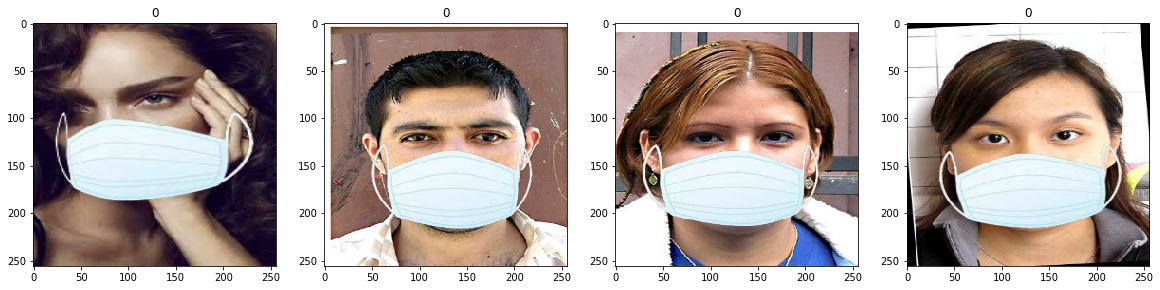

In [14]:
# Plots images with class number to help identify which class no. belong to which label
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 2. Preprocess Data


### 2.1 Scale Data

In [15]:
# .map allows you to scale data in the pipeline x = images y = labels
data = data.map(lambda x,y: (x/255,y))

In [18]:
# Check min() and max() min should = 0.0 max should = 1.0
data.as_numpy_iterator().next()[0].min()

0.0

### 2.2 Split Data

In [19]:
len(data)

43

In [20]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)

In [21]:
# Total should be the same as your total length of data 
train_size+val_size+test_size

43

In [22]:
# Adding batch size 
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

### 3. Deep Model

### 3.1 Build Deep Learning Model

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [30]:
model = Sequential()

In [32]:
# 16 filters of 3x3 and moves 1 pixel each time (stride)
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

# Sigmoid takes any output and converts it to a range for 0-1 which maps to your classes
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [34]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)      

### 3.2 Training

In [37]:
logdir='logs'

In [38]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [39]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
30/30 [==============================] - 13s 92ms/step - loss: 0.6986 - accuracy: 0.5854 - val_loss: 0.4844 - val_accuracy: 0.8715
Epoch 2/20
30/30 [==============================] - 3s 88ms/step - loss: 0.2604 - accuracy: 0.9115 - val_loss: 0.1265 - val_accuracy: 0.9688
Epoch 3/20
30/30 [==============================] - 3s 86ms/step - loss: 0.1230 - accuracy: 0.9594 - val_loss: 0.1428 - val_accuracy: 0.9514
Epoch 4/20
30/30 [==============================] - 3s 86ms/step - loss: 0.0951 - accuracy: 0.9698 - val_loss: 0.0843 - val_accuracy: 0.9826
Epoch 5/20
30/30 [==============================] - 3s 87ms/step - loss: 0.0815 - accuracy: 0.9750 - val_loss: 0.0442 - val_accuracy: 0.9861
Epoch 6/20
30/30 [==============================] - 3s 85ms/step - loss: 0.0600 - accuracy: 0.9792 - val_loss: 0.0230 - val_accuracy: 0.9965
Epoch 7/20
30/30 [==============================] - 3s 85ms/step - loss: 0.0437 - accuracy: 0.9833 - val_loss: 0.0388 - val_accuracy: 0.9896
Epoch 8/20
3

### 3.3 Plotting Performance

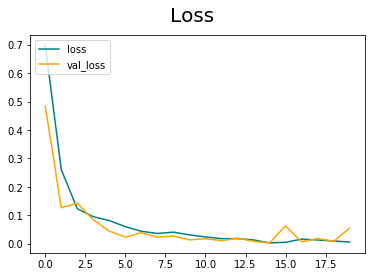

In [40]:
# If loss is going down and val_loss is going up model might be overfitting (Change some data?)
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

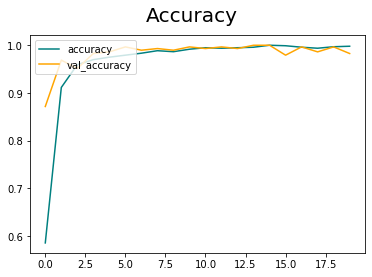

In [41]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 4. Evaluate Performance

### 4.1 Evaluate

In [43]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [44]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [46]:
# Loops through batches in testing data
# X = images
# Passes image data to model to predict
# Update metrics 
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)

In [48]:
# Higher value = better
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.9923076629638672, Recall:0.9772727489471436, Accuracy:0.984375


### 4.2 Test

In [49]:
import cv2

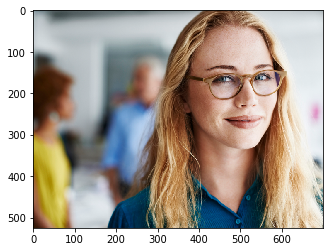

In [61]:
img = cv2.imread('No_Mask-test.jpg')
# OpenCV reads as BGR instead of RGB so we convert it here
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

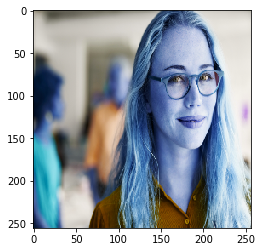

In [62]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [63]:
# The neutral network expects a batch of images not a single image
# So we encapsulate it inside of a list
yhat = model.predict(np.expand_dims(resize/255,0))

In [64]:
yhat

array([[0.04884427]], dtype=float32)

In [65]:
if yhat > 0.5 :
    print(f'Predicted Class is Wearing a Mask')
else:
    print(f'Predicted Class is NOT Wearing a Mask')

Predicted Class is NOT Wearing a Mask


# 5. Save the Model

### 5.1 Save the Model

In [66]:
from tensorflow.keras.models import load_model

In [67]:
model.save(os.path.join('models', 'model-mask-or-no.h5'))

In [68]:
new_model = load_model(os.path.join('models', 'model-mask-or-no.h5'))

In [72]:
yhat_new = new_model.predict(np.expand_dims(resize/255,0))

In [73]:
if yhat_new > 0.5 :
    print(f'Predicted Class is Wearing a Mask')
else:
    print(f'Predicted Class is NOT Wearing a Mask')

Predicted Class is NOT Wearing a Mask
